# Quantifying Immune Infiltration

Software packages which characterize the cellular composition of tumor immune infiltrates fall under two categories, gene set enrichment analysis (GSEA) and deconvolution methods. We provide an overview of each of these methods and an overview of relevant packages in each category. For each software tool, we then describe how we might (or might not) compare it to Adaptive’s TCF.

## Gene Set Enrichment Analysis (GSEA)
GSEA analyzes multiple samples, generating enrichment scores for each which represent the degree to which the gene set distinguishes between phenotypes. ssGSEA (single sample GSEA)  analyzes a single sample, generating an enrichment score corresponding with the degree to which the genes in the gene set are coordinately up- or down- regulated.

Most (or all?) software tools characterizing tumor immune infiltrate under this category use ssGSEA. Under ssGSEA, one can compare samples under the same gene set, but not scores from different gene sets within a particular sample. For instance, if ssGSEA analyzed the following samples,
<table>
    <tr>
        <td></td>
        <th>CD4+ T-Cells</th>
        <th>CD8+ T-Cells</th>
    </tr>
    <tr>
        <th>Sample1</th>
        <td>1800</td>
        <td>21000</td>
    </tr>
    <tr>
        <th>Sample2</th>
        <td>2100</td>
        <td>19000</td>
    </tr>
</table>

we could claim that Sample1 has more CD4+ T-cells than Sample2, but not that Sample1 has more CD4+ T-cells than CD8+ T-cells. (In this example, we’d have a gene set for both CD4+ T-cells and CD8+ T-cells.)

## Deconvolution
Deconvolution methods attempt to infer proportions of different cell populations in a particular tissue sample. In contrast to GSEA, deconvolution methods allow us to compare inferences of different cell types.

The deconvolution problem setup is as follows. Imagine we have N genes and M cell types of interest. We have a vector `m` of size N which holds the gene expression profile from the tissue sample, a reference matrix of expression profiles `S` of size NxM, and a vector `f` of size M which represents the proportions of each cell type in the sample. Then, `m = S x f`, and we want to solve for `f`.

In [23]:
library(dplyr)
library(tibble)
library(ggplot2)
library(stringr)
library(readr)

In [2]:
# Helper Functions

# scores1 and scores2 should have two columns, "Sample Name", "score", and "method"
build_score_df <- function(scores1, scores2) {
    scores1 %>%
        rename(score1 = score, method1 = method) %>%
        inner_join(scores2, by = "Sample Name") %>%
        rename(score2 = score, method2 = method)
}

# Creates a bland-altman plot for the given scores dataframe (created by `build_scores_df`).
# The `xcol` parameter specifies which per-sample data point should be used as the x axis.
# The default, "avg", specifies that the average of the two scores should be used. Other viable
# options include "score1" and "score2".
bland_altman <- function(scores, xcol = "avg") {        
    scores <- scores %>%
              mutate(avg  = (score1 + score2) / 2,
                     diff = abs(score1 - score2))

    summaries <- scores %>%
                 group_by(method1, method2) %>% 
                 summarize(mean = mean(diff), sd = sd(diff), r = cor(score1, score2))

    # For correlation coefficient labels. `avg` and `diff` must be defined, as they designate
    # where the label is positioned, but since we use `hjust` and `vjust` to position the labels
    # in the top-right of each plot, these x/y values are essentially no-ops. Note that this still
    # includes the `method` column, which ends up choosing a single label per method/plot.
    labels <- summaries %>%
              mutate(!!xcol := Inf, diff = Inf, labels = paste("r = ", r))

    plot <-
        ggplot(scores, aes_string(xcol, "diff")) +
        geom_point() +
        geom_hline(data = summaries, aes(yintercept = mean), color = "blue") +
        geom_hline(data = summaries, aes(yintercept = mean + 1.96 * sd), color = "red", linetype = "dashed") +
        geom_hline(data = summaries, aes(yintercept = mean - 1.96 * sd), color = "red", linetype = "dashed") +
        geom_text(data = labels, aes(label = labels), hjust = "right", vjust = "top", size = 4)
    
    if (nrow(summaries) > 1)
        plot = plot + facet_wrap(method1 ~ method2, scales = "free", ncol = 2)
    else
        plot = plot + ggtitle(paste(scores[1, 'method1'], " v. ", scores[1, 'method2']))
    
    plot
}

# Shortcut function for creating a single bland-altman plot.
bland_altman_single <- function(scores1, scores2, xcol = "avg") {
    bland_altman(build_score_df(scores1, scores2), xcol)
}
        
head3 <- function(x, ...) { head(x, n=3, ...) }

# 1. Load Data for Each Method

## Adaptive TCF

*(White) Paper:* http://www.adaptivebiotech.com/sites/default/files/knowledge-center/resources/MRK-10013%2

Adaptive’s RNA-seq white paper mentions that it only includes “productive sequences,” functional TCR sequences. It is computed as

$$TCF = \frac{\text{T-cells in sample}}{\text{Cells in sample}}$$

We load all three measurements in this equation from the clinical data, which we use in various ways for comparing relative and absolute T-cell abundances to computational methods.

In [3]:
# We need to go through 2 files in order to map from kallisto folder names (aka "BAM Name")
# to Patient IDs, using "MGI DNA Name" as a proxy to get from the former to the latter.
adaptive <- read_tsv("2850417_Neoantigen_RNA_bams.csv", col_names = c("MGI DNA Name", "BAM Name")) %>%

            # This extracts the part of the BAM Name we want to match.
            mutate(`BAM Name` = str_extract(`BAM Name`, "(gerald[^\\.]+)")) %>%

            left_join(read_csv("sequencing_manifest.csv"), by = "MGI DNA Name") %>%

            # Patient IDs are numbers here, but are padded strings in `tcr_master.csv`.
            # We want pre-therapy numbers, so we specify timepoint A.
            mutate(`Subject ID` = paste(str_pad(`Individual Name`, 4, pad="0"), "-A", sep="")) %>%

            select("BAM Name", "Subject ID") %>%
            left_join(read_csv("tcr_master.csv"), by = "Subject ID") %>%
            filter(`Sample Type` == "Tumor") %>%
            select("BAM Name", TCF = "T-cell fraction", TCR = "Productive TCR Templates(cnt)", ncells = "Cell count") %>%

            # We deal with periods only throughout the pipeline, for simplicity.
            # (Some tools convert _/- automatically, so it's easier to always use the period.)
            mutate(`BAM Name` =  str_replace_all(`BAM Name`, "-|_", ".")) %>%

            rename(`Sample Name` = `BAM Name`)

adaptive_tcf <-
    adaptive %>%
    select(`Sample Name`, score = TCF) %>%
    mutate(method = "Adaptive Relative") %>%
    as.data.frame
adaptive_ntcr <-
    adaptive %>%
    select(`Sample Name`, score = TCR) %>%
    mutate(method = "Adaptive Absolute") %>%
    as.data.frame
adaptive_ncells <-
    adaptive %>%
    select(`Sample Name`, ncells) %>%
    as.data.frame

head3(adaptive_tcf)
head3(adaptive_ntcr)
head3(adaptive_ncells)

Parsed with column specification:
cols(
  `MGI DNA Name` = col_character(),
  `BAM Name` = col_character()
)
Parsed with column specification:
cols(
  `Individual Name` = col_integer(),
  `Sample Name` = col_character(),
  `DNA Type` = col_character(),
  `Tissue Name` = col_character(),
  `Common Name` = col_character(),
  `MGI DNA Name` = col_character(),
  `Sequence Plan` = col_character(),
  Status = col_character()
)
Parsed with column specification:
cols(
  `Subject ID` = col_character(),
  `Sample ID` = col_character(),
  Product = col_character(),
  `Sample Type` = col_character(),
  `Time Point` = col_character(),
  `Clinical Response` = col_character(),
  `Cell count` = col_double(),
  `Productive TCR Templates(cnt)` = col_double(),
  `T-cell fraction` = col_double(),
  Clonality = col_double(),
  Diversity = col_double(),
  `Productive Unique TCRs (cnt)` = col_integer(),
  `TCR Templates` = col_integer(),
  `Top Clone Freq(%)` = col_double(),
  `Unique TCRs(cnt)` = col_intege

Sample Name,score,method
gerald.H5NKVBBXX.6.GAATTCGT.ATAGAGGC,0.0710,Adaptive Relative
gerald.H5NKVBBXX.6.TCTCGCGC.TATAGCCT,0.0588,Adaptive Relative
gerald.H5NKVBBXX.5.ATTACTCG.ATAGAGGC,0.1017,Adaptive Relative


Sample Name,score,method
gerald.H5NKVBBXX.6.GAATTCGT.ATAGAGGC,1106.8906,Adaptive Absolute
gerald.H5NKVBBXX.6.TCTCGCGC.TATAGCCT,62.5826,Adaptive Absolute
gerald.H5NKVBBXX.5.ATTACTCG.ATAGAGGC,6693.8559,Adaptive Absolute


Sample Name,ncells
gerald.H5NKVBBXX.6.GAATTCGT.ATAGAGGC,15588.483
gerald.H5NKVBBXX.6.TCTCGCGC.TATAGCCT,1064.358
gerald.H5NKVBBXX.5.ATTACTCG.ATAGAGGC,65787.816


## xCell

*Paper:* http://www.biorxiv.org/content/early/2017/06/15/114165

xCell uses 3 gene signatures for each cell type and averages their ssGSEA scores on each sample.

The authors found that ssGSEA scores don’t linearly scale with actual cell-type abundance. They transformed the scores using a power function so that they do. (I did not learn or read about this more deeply, so I don't have a full understanding of how and if this works.)

They also observed dependencies between closely related cell types – scores for similar cell types might be coordinately large, even if one of the cell types is not in the mixture. They generated a spillover matrix to compensate for these dependencies.

For xCell comparisons, we add up all T-cell scores together. In the world of ssGSEA, this is an invalid operation, but it's a simple way to get started. Further work should learn more about the cell hierarchy xCell defines and choose a single appropriate ssGSEA score for comparison to the TCF.

In [5]:
# Note: This defines some kind of a hierarchy, but I'm just adding up every score.
tcell.columns <- c(
    "CD4+ memory T-cells",
    "CD4+ naive T-cells",
    "CD4+ T-cells",
    "CD4+ Tcm",
    "CD4+ Tem",
    "CD8+ naive T-cells",
    "CD8+ T-cells",
    "CD8+ Tcm",
    "CD8+ Tem",
    "Tgd cells",
    "Th1 cells",
    "Th2 cells",
    "Tregs")

xcell <- 
    read_tsv("xcell-output.tsv") %>%
    column_to_rownames("CellType") %>%
    t %>%
    as.data.frame %>%
    select(tcell.columns) %>%
    rowSums %>%
    as.data.frame %>%
    rename(`score` = ".") %>%
    rownames_to_column("Sample Name") %>%
    mutate(method = "xCell") %>%
    as.data.frame

head3(xcell)

Parsed with column specification:
cols(
  .default = col_double(),
  CellType = col_character()
)
See spec(...) for full column specifications.
Warning message:
“Setting row names on a tibble is deprecated.”

Sample Name,score,method
gerald.H5NKVBBXX.4.CGGCTATG.TATAGCCT,0.08858287,xCell
gerald.H5NKVBBXX.4.CTGAAGCT.ATAGAGGC,0.09069868,xCell
gerald.H5NKVBBXX.4.TAATGCGC.ATAGAGGC,0.09591669,xCell


## ESTIMATE

*Paper:* https://www.nature.com/articles/ncomms3612

ESTIMATE computes three scores: the stromal score, the immune score, and the ESTIMATE score. The stromal and immune scores are computed using ssGSEA, and the ESTIMATE score is a combination of them.


In [6]:
estimate_base <-
    read_tsv("estimate-output.gct", comment="#", skip=1) %>%
    select(-`NAME`) %>%
    as.data.frame %>%
    column_to_rownames("Description") %>%
    t %>%
    as.data.frame %>%
    rownames_to_column("Sample Name")
    
estimate <-
    estimate_base %>%
    select(`Sample Name`, score = "ImmuneScore") %>%
    mutate(method = "ESTIMATE") %>%
    as.data.frame

head3(estimate)

Parsed with column specification:
cols(
  .default = col_double(),
  NAME = col_character(),
  Description = col_character()
)
See spec(...) for full column specifications.


Sample Name,score,method
gerald.H5NKVBBXX.4.CGGCTATG.TATAGCCT,8832.098,ESTIMATE
gerald.H5NKVBBXX.4.CTGAAGCT.ATAGAGGC,8467.179,ESTIMATE
gerald.H5NKVBBXX.4.TAATGCGC.ATAGAGGC,10571.649,ESTIMATE


## CIBERSORT

*Paper:* http://www.nature.com/nmeth/journal/v12/n5/abs/nmeth.3337.html

CIBERSORT performs deconvolution on gene expression data using the LM22 leukocyte gene signature matrix, which consists of 547 genes that distinguish 22 immune cell types. It uses nu-SVR to solve for `f`.

Of note is that `f` consists of intra-sample leukocyte fractions, and so it’s impossible to compare fractions across samples.

Here, we load two versions of the CIBERSORT results -- a *relative* T-cell fraction and an *absolute* T-cell fraction. The former is the fraction of leukocyte cells that CIBERSORT predicts to be T-cells; in theory, the latter is the *absolute* number of T-cells that CIBERSORT predicts to be in the sample, which is computed by multiplying the relative fraction with the total number of cells in the sample, as reported by Adaptive. The way this is done now is wrong, as we are multiplying CIBERSORT's intra-leukocyte TCF with the total number of samples. We really need a way to quantify the number of immune cells in the sample more generally.

In [47]:
tcell.columns = c(
    'T.cells.CD8',
    'T.cells.CD4.naive',
    'T.cells.CD4.memory.resting',
    'T.cells.CD4.memory.activated',
    'T.cells.follicular.helper',
    'T.cells.regulatory..Tregs.',
    'T.cells.gamma.delta'
)

cibersort_base <-
    read_tsv("cibersort-output.tsv", comment=">") %>%
    as.data.frame %>%
    column_to_rownames("Sample Name") %>%
    select(tcell.columns) %>%
    rowSums %>%
    as.data.frame %>%
    rename(`score` = ".") %>%
    rownames_to_column("Sample Name")

cibersort_relative <- cibersort_base %>%
    mutate(method = "CIBERSORT Relative") %>%
    as.data.frame

cibersort_absolute <- cibersort_base %>%
    left_join(adaptive_ncells, by = "Sample Name") %>%
    filter(!is.na(ncells)) %>%
    mutate(method = "CIBERSORT Absolute") %>%
    mutate(score = score * ncells) %>%
    select(-ncells) %>%
    as.data.frame

head3(cibersort_base)
head3(cibersort_relative)
head3(cibersort_absolute)

Parsed with column specification:
cols(
  .default = col_double(),
  `Sample Name` = col_character(),
  T.cells.gamma.delta = col_integer(),
  Dendritic.cells.resting = col_integer()
)
See spec(...) for full column specifications.


Sample Name,score
gerald.H5NKVBBXX.4.CGGCTATG.TATAGCCT,0.4590312
gerald.H5NKVBBXX.4.CTGAAGCT.ATAGAGGC,0.2074370
gerald.H5NKVBBXX.4.TAATGCGC.ATAGAGGC,0.2690131


Sample Name,score,method
gerald.H5NKVBBXX.4.CGGCTATG.TATAGCCT,0.4590312,CIBERSORT Relative
gerald.H5NKVBBXX.4.CTGAAGCT.ATAGAGGC,0.2074370,CIBERSORT Relative
gerald.H5NKVBBXX.4.TAATGCGC.ATAGAGGC,0.2690131,CIBERSORT Relative


Sample Name,score,method
gerald.H5NKVBBXX.4.CGGCTATG.TATAGCCT,4603.212,CIBERSORT Absolute
gerald.H5NKVBBXX.4.TAATGCGC.ATAGAGGC,6059.192,CIBERSORT Absolute
gerald.H5NKVBBXX.4.TAATGCGC.TATAGCCT,10677.919,CIBERSORT Absolute


## MCP-Counter

*Paper:* https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5073889/

MCP-Counter identifies transcriptomic markers (TM) to identify cell populations; TMs are like GEPs, but are only expressed in a single cell population with little variance within said population.

The objective of MCP-Counter is to allow for inter-sample comparison of relative abundances of cell populations, which CIBERSORT does not allow. In this sense, MCP-Counter is more like one of the previously described GSEA methods, even though it uses deconvolution approaches to solve the problem.

MCP-Counter has three different scores related to T-cells: "T cells", "CD8 T cells", and "Cytotoxic lymphocytes". It is unclear which corresponds to what cells, but for now we assume the generic "T cells" category is best for comparison.

In [12]:
tcell.columns = c(
    'T cells'
#     'CD8 T cells'
#     'Cytotoxic lymphocytes'
)

mcp <-
    read_tsv("mcpcounter-output.tsv") %>%
    as.data.frame %>%
    column_to_rownames("CellType") %>%
    t %>%
    as.data.frame %>%
    select(tcell.columns) %>%
    rowSums %>%
    as.data.frame %>%
    rownames_to_column("Sample Name") %>%
    mutate(method = "MCP") %>%
    rename(score = ".") %>%
    as.data.frame

head3(mcp)

Parsed with column specification:
cols(
  .default = col_double(),
  CellType = col_character()
)
See spec(...) for full column specifications.


Sample Name,score,method
gerald.H5NKVBBXX.4.CGGCTATG.TATAGCCT,258.03017,MCP
gerald.H5NKVBBXX.4.CTGAAGCT.ATAGAGGC,42.36974,MCP
gerald.H5NKVBBXX.4.TAATGCGC.ATAGAGGC,63.67254,MCP


# 2. Comparing Methods

Correlation works best on normally distributed data. As such, we plot the densities of each method's measurements to see if we should transform the data to a log scale.

## Adaptive

Adaptive's TCF seems normally distributed on a log-scale.

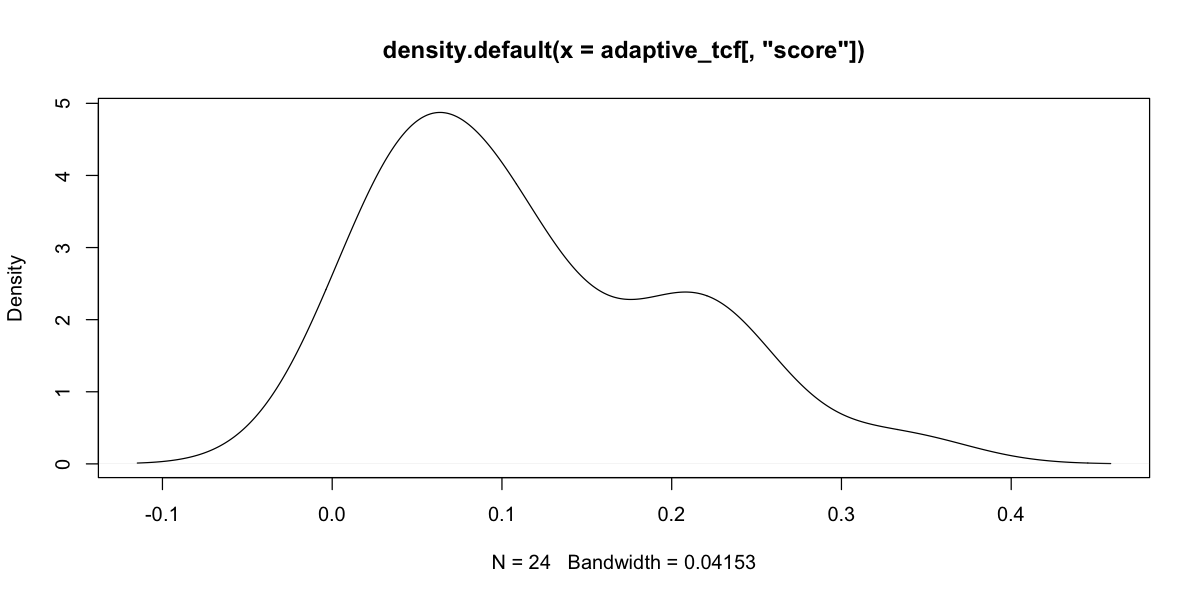

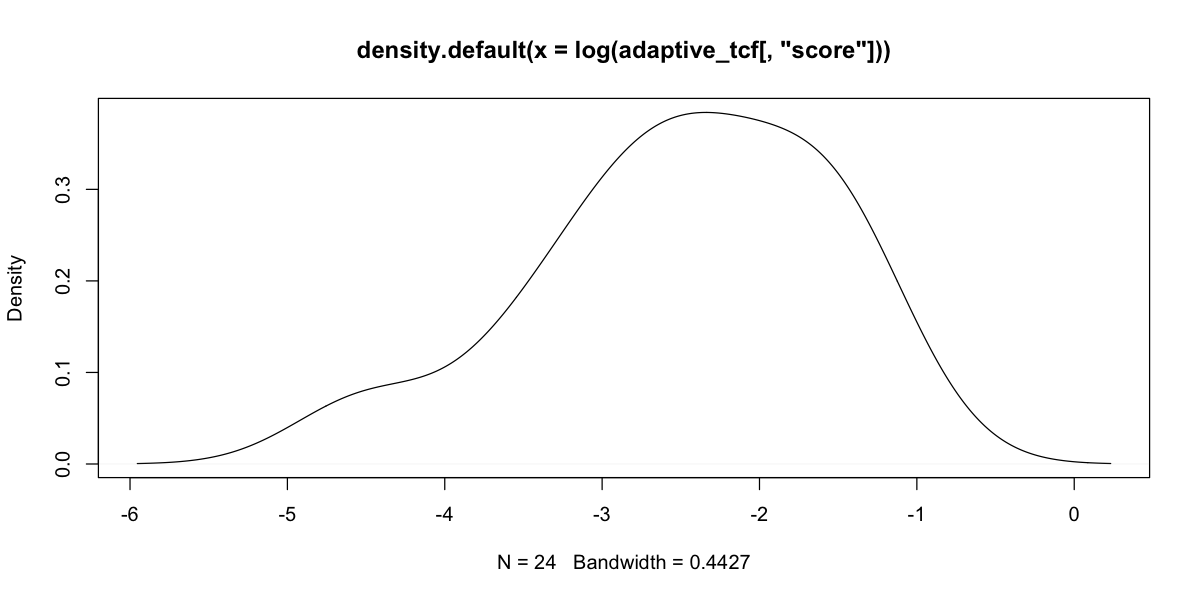

In [16]:
options(repr.plot.width=10, repr.plot.height=5)
plot(density(adaptive_tcf[,'score']))
plot(density(log(adaptive_tcf[,'score'])))

## Adaptive v. CIBERSORT

CIBERSORT's scores seem somewhat normally distributed.

It's important to note that Adaptive's Cibersort's TCF have different denominators (total cells and total immune cells, respectively), so it's difficult to do a fair comparison. Absolute measurements may help.


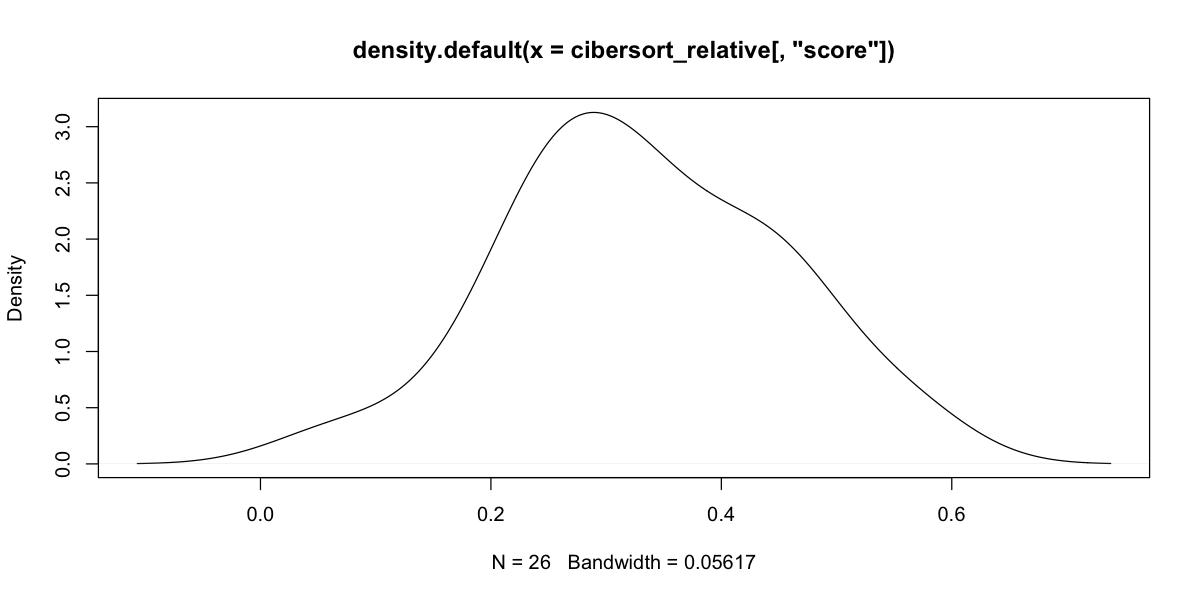

In [17]:
plot(density(cibersort_relative[,'score']))

Interestingly, by comparing absolute and relative values, we get wildly different correlations.

(Addendum: See CIBERSORT description above. These absolute calculations are wrong and so these comparisons don't make much sense.)

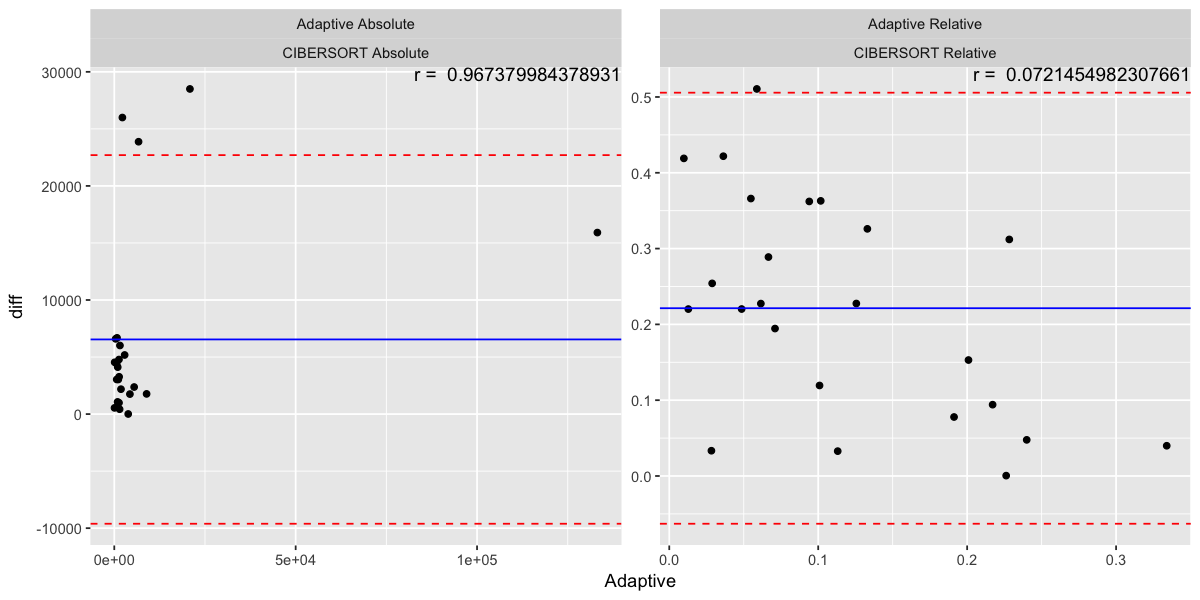

In [26]:
options(repr.plot.width=10, repr.plot.height=5)
bland_altman(
    bind_rows(
        build_score_df(adaptive_ntcr, cibersort_absolute),
        build_score_df(adaptive_tcf, cibersort_relative)
    ),
    xcol = "score1") + xlab("Adaptive")

If we remove the four obvious outliers from the absolute comparison, correlation decreases significantly. (Outliers can affect correlation significantly.)

Thus, these results are probably expected.

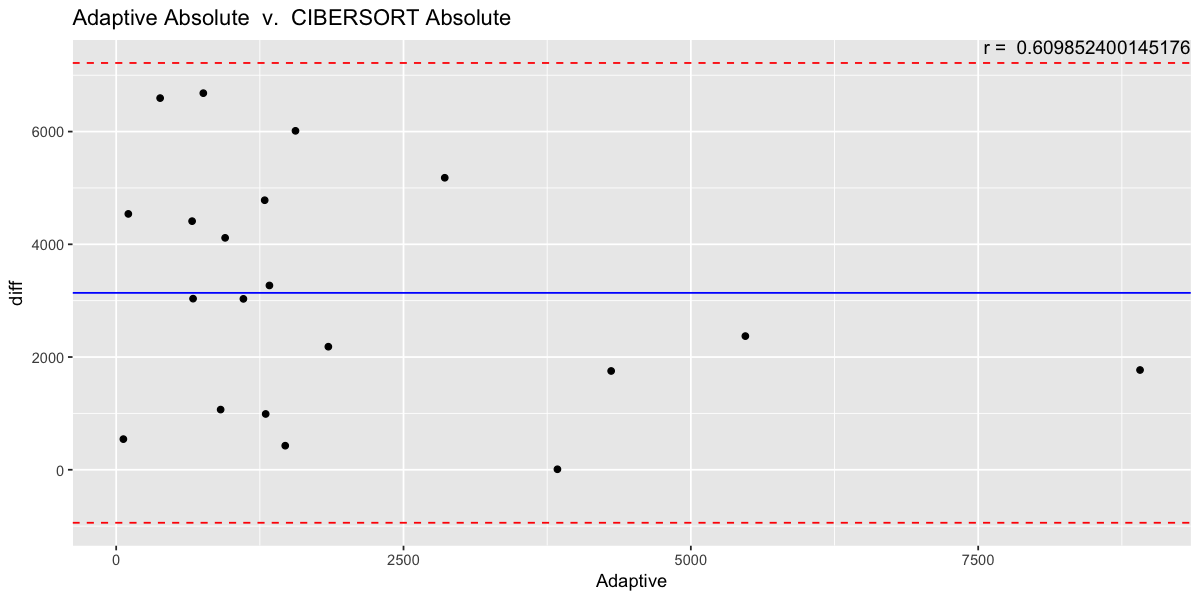

In [27]:
df <- build_score_df(adaptive_ntcr, cibersort_absolute) %>%
    filter(rank(score1 - score2) > 4) %>%
    mutate(diff = score2 - score1)
options(repr.plot.width=10, repr.plot.height=5)
print(bland_altman(df, xcol = "score1") + xlab("Adaptive"))

Since CIBERSORT and Adaptive have different scales (total immune cells and total cells, respectively), we try comparing percentile scores.

Note that this doesn't fix the fact that the two quantities measure different things, but it *does* put both fractions on the same percentile scale. Rank (see below) has the same effect.

Sample Name,score,method
gerald.H5NKVBBXX.6.GAATTCGT.ATAGAGGC,0.4583333,Adaptive TCF Percentile
gerald.H5NKVBBXX.6.TCTCGCGC.TATAGCCT,0.3333333,Adaptive TCF Percentile
gerald.H5NKVBBXX.5.ATTACTCG.ATAGAGGC,0.5833333,Adaptive TCF Percentile


Sample Name,score,method
gerald.H5NKVBBXX.4.CGGCTATG.TATAGCCT,0.8846154,CIBERSORT Percentile
gerald.H5NKVBBXX.4.CTGAAGCT.ATAGAGGC,0.1153846,CIBERSORT Percentile
gerald.H5NKVBBXX.4.TAATGCGC.ATAGAGGC,0.3461538,CIBERSORT Percentile


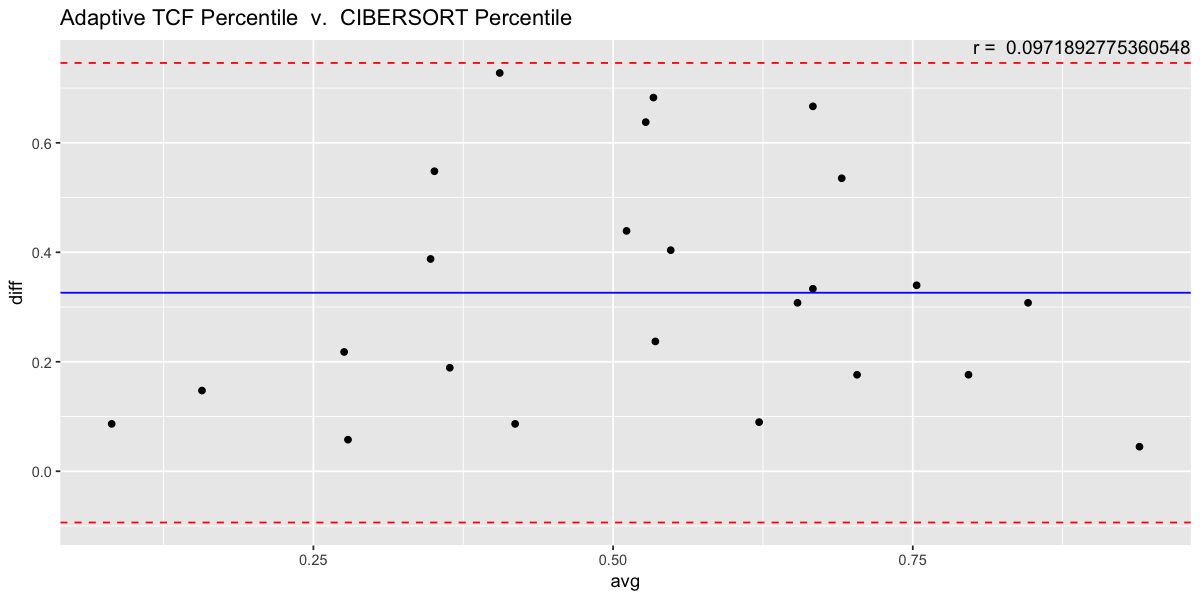

In [28]:
tcf_percentile_fn <- ecdf(adaptive_tcf[,'score'])
adaptive_tcf_percentile <- adaptive_tcf %>% mutate(score = tcf_percentile_fn(score), method = "Adaptive TCF Percentile")

cibersort_percentile_fn <- ecdf(cibersort_relative[,'score'])
cibersort_percentile <- cibersort_relative %>% mutate(score = cibersort_percentile_fn(score), method = "CIBERSORT Percentile")

head3(adaptive_tcf_percentile)
head3(cibersort_percentile)
bland_altman(build_score_df(adaptive_tcf_percentile, cibersort_percentile))

Sample Name,score,method
gerald.H5NKVBBXX.6.GAATTCGT.ATAGAGGC,11,Adaptive TCF Rank
gerald.H5NKVBBXX.6.TCTCGCGC.TATAGCCT,8,Adaptive TCF Rank
gerald.H5NKVBBXX.5.ATTACTCG.ATAGAGGC,14,Adaptive TCF Rank


Sample Name,score,method
gerald.H5NKVBBXX.4.CGGCTATG.TATAGCCT,23,CIBERSORT Rank
gerald.H5NKVBBXX.4.CTGAAGCT.ATAGAGGC,3,CIBERSORT Rank
gerald.H5NKVBBXX.4.TAATGCGC.ATAGAGGC,9,CIBERSORT Rank


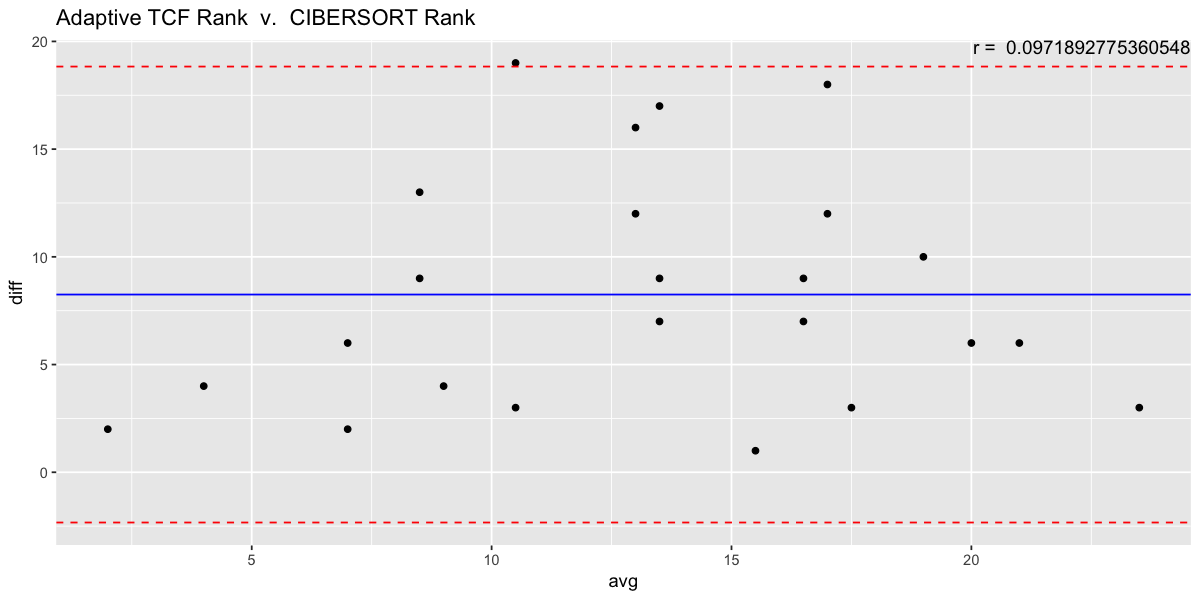

In [30]:
adaptive_tcf_rank <- adaptive_tcf %>% mutate(score = rank(score), method = "Adaptive TCF Rank")

cibersort_rank <- cibersort_relative %>% mutate(score = rank(score), method = "CIBERSORT Rank")

head3(adaptive_tcf_rank)
head3(cibersort_rank)
bland_altman(build_score_df(adaptive_tcf_rank, cibersort_rank))

It seems like CIBERSORT compares fairly poorly with Adaptive's TCF calculation. Why might this be the case?

1. Adaptive's TCF is a fraction of *all* cells, whereas CIBERSORT's is a fraction of all *immune* cells.
It may be worth adjusting these scores with an estimate of non-immune cells.
Adjustments must be made per-sample --
I wonder if we could adjust CIBERSORT scores using scores from other methods for non-immune cells (e.g., ESTIMATE's ImmuneScore as a normalized fraction).
2. Tumor cells in the sample look too much like T-cells or non-T-immune-cells, messing up the ratios given by CIBERSORT.
3. CIBERSORT has produced poor estimates for this cohort (high p-values or inaccurate proportions regardless of p-value).

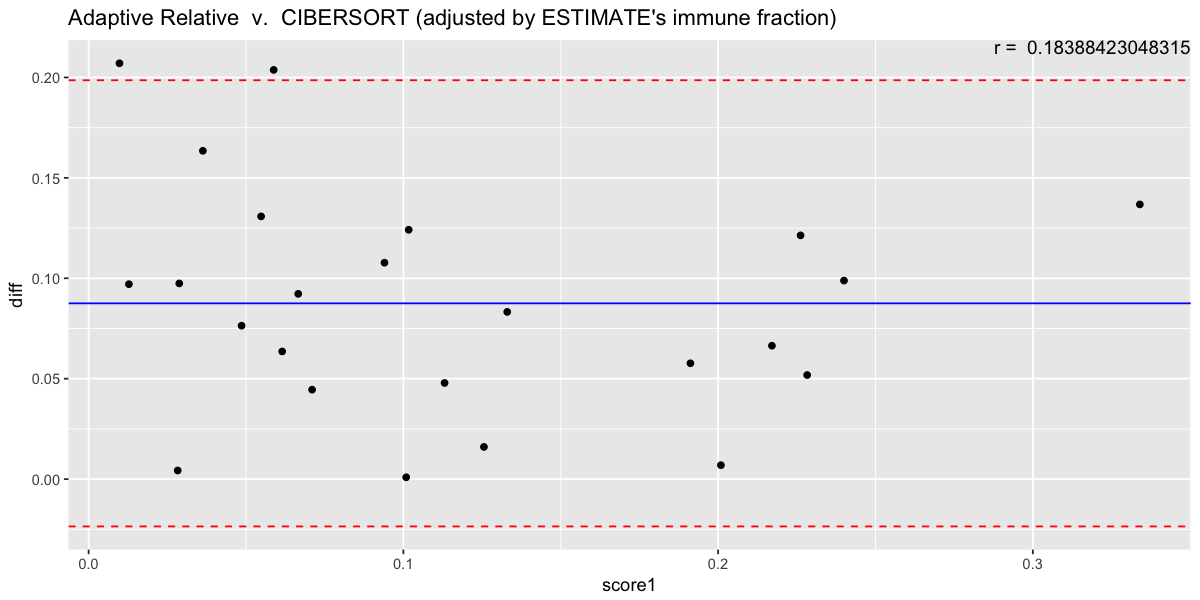

In [46]:
immune_fraction <-
    estimate_base %>%
    mutate(immune = ImmuneScore / ESTIMATEScore) %>%
    select(`Sample Name`, immune)

cibersort_total_fraction <-
    cibersort_relative %>%
    left_join(immune_fraction, by = "Sample Name") %>%
    mutate(score = score * immune, method = "CIBERSORT (adjusted by ESTIMATE's immune fraction)") %>%
    select(-immune)

bland_altman_single(adaptive_tcf, cibersort_total_fraction, xcol = "score1")

# Adaptive v. MCP-Counter

It seems that MCP-Counter's score are normal on a log-scale.

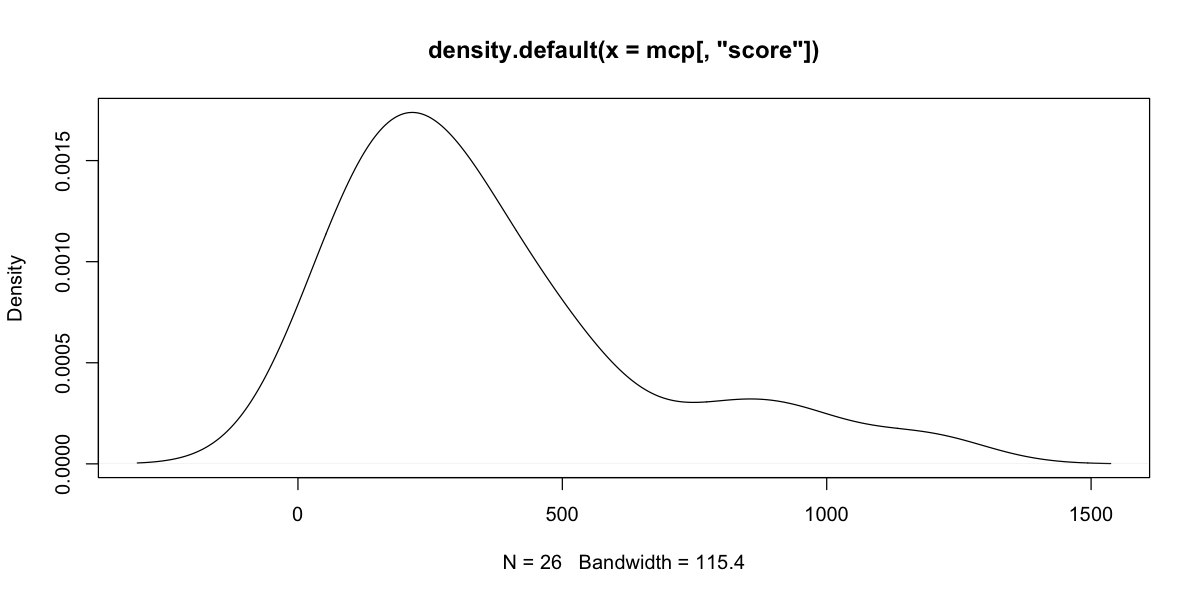

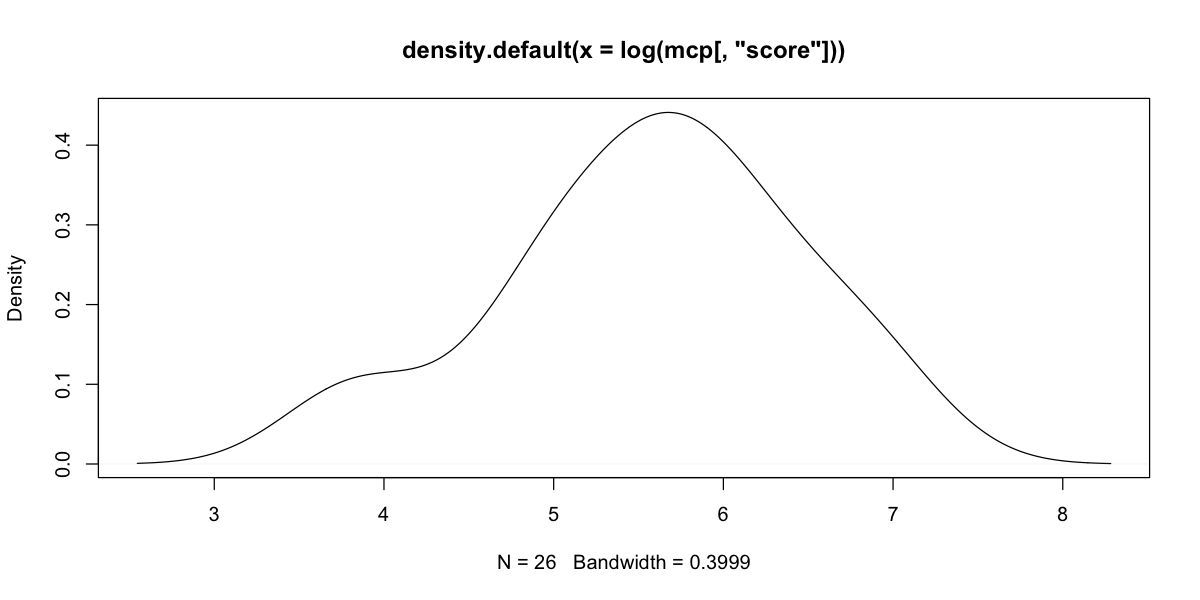

In [32]:
plot(density(mcp[,'score']))
plot(density(log(mcp[,'score'])))

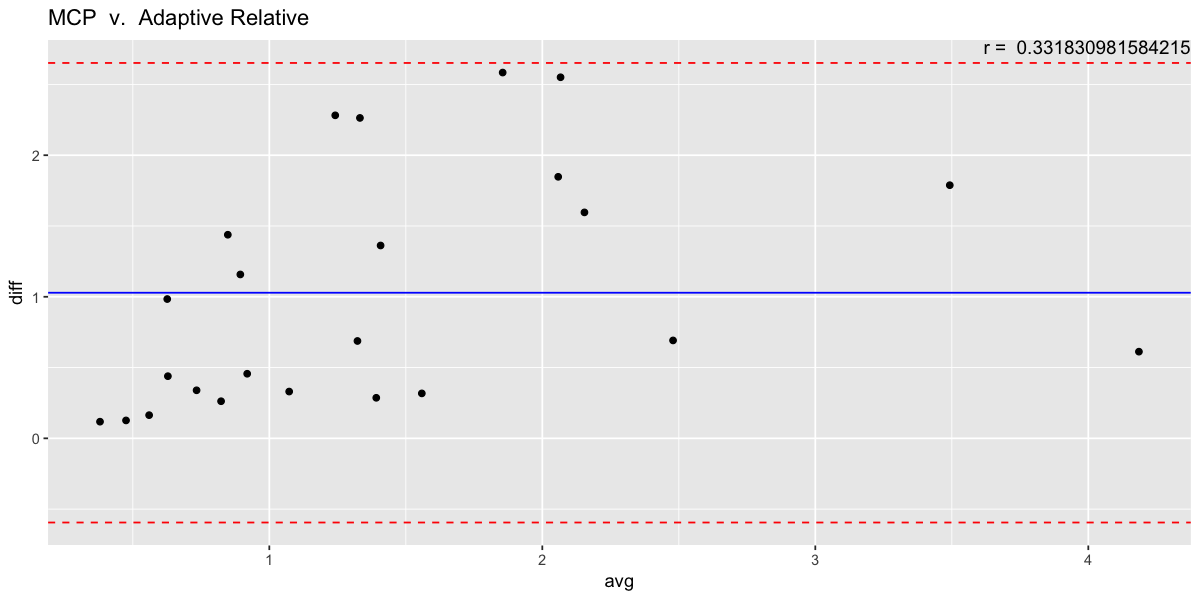

In [33]:
normalized_mcp <-
    mcp %>%
    mutate(score = log(score), score = (score - mean(score)) / sd(score), score = exp(score))

normalized_adaptive_tcf <-
    adaptive_tcf %>%
    mutate(score = log(score), score = (score - mean(score)) / sd(score), score = exp(score))

bland_altman_single(normalized_mcp, normalized_adaptive_tcf)

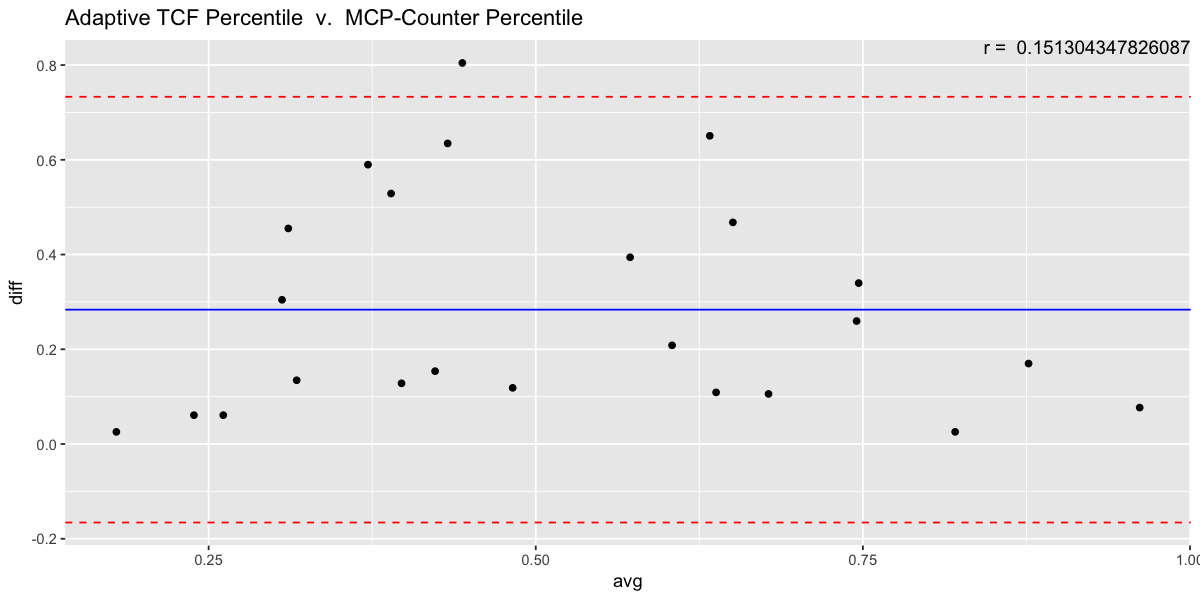

In [34]:
mcp_percentile_fn <- ecdf(mcp[,'score'])
mcp_percentile <- mcp %>% mutate(score = mcp_percentile_fn(score), method = "MCP-Counter Percentile")

bland_altman_single(adaptive_tcf_percentile, mcp_percentile)

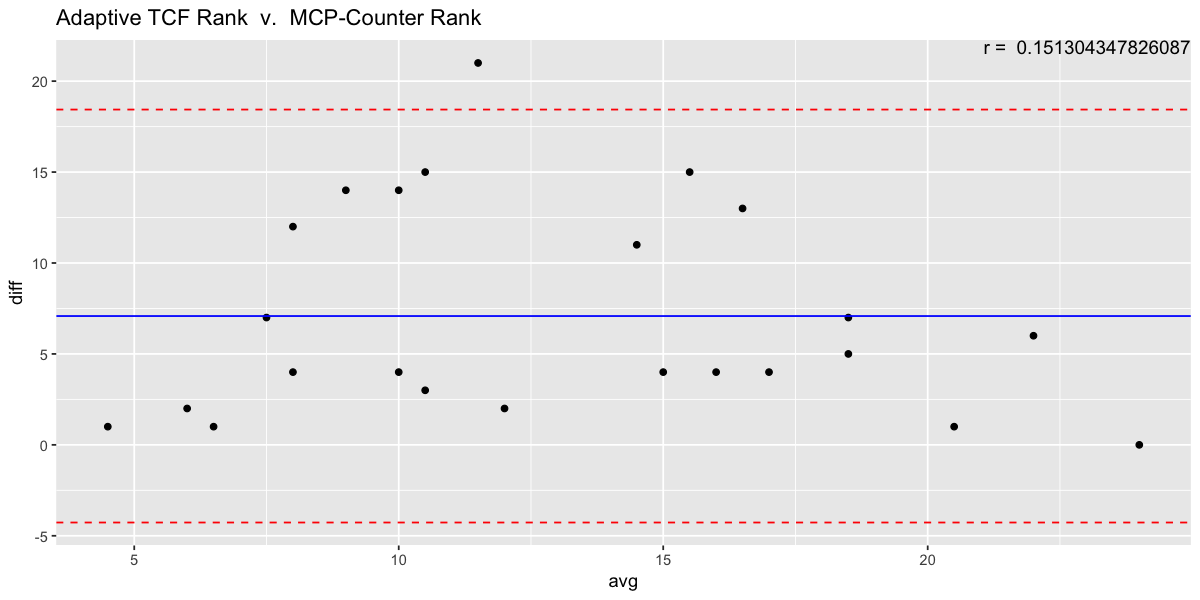

In [35]:
mcp_rank <- mcp %>% mutate(score = rank(score), method = "MCP-Counter Rank")
bland_altman_single(adaptive_tcf_rank, mcp_rank)

## Adaptive v. xCell

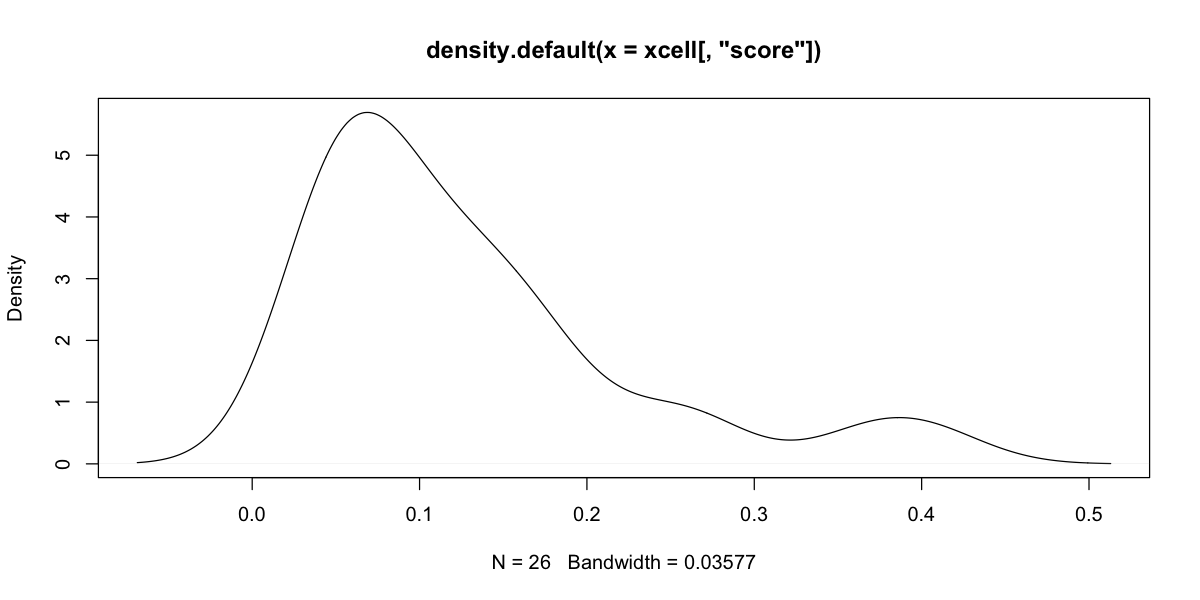

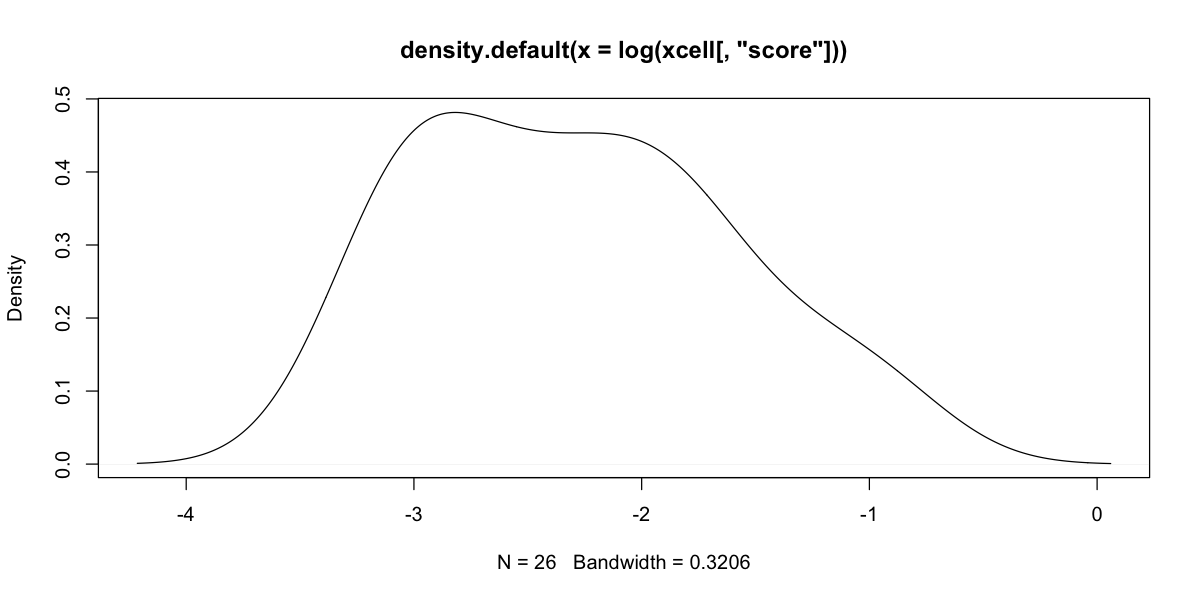

In [36]:
plot(density(xcell[,'score']))
plot(density(log(xcell[,'score'])))

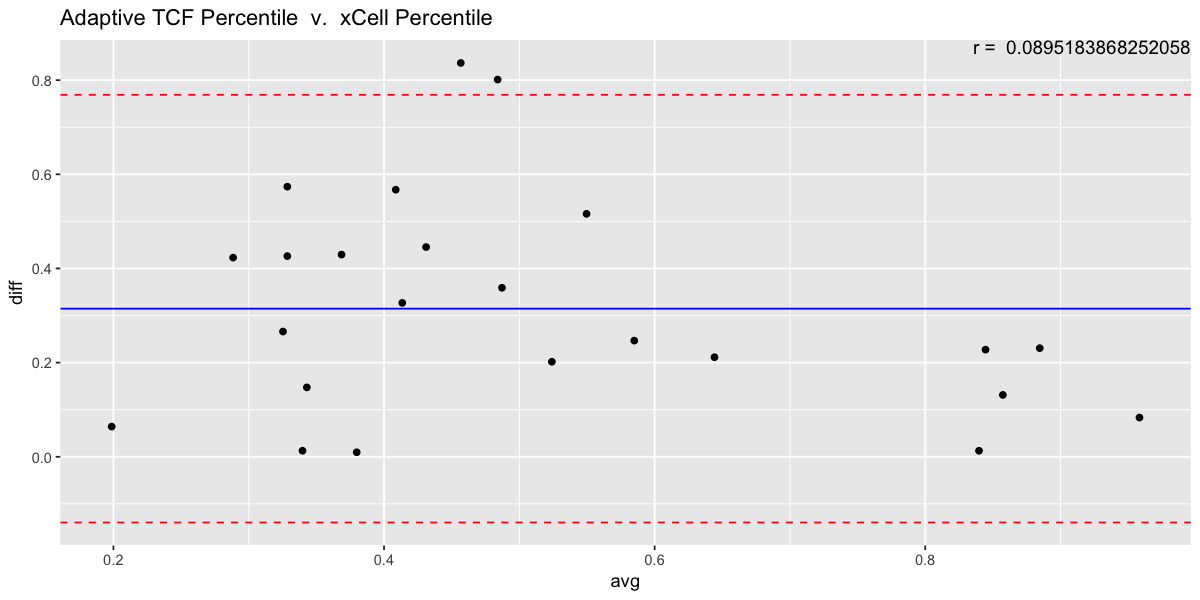

In [37]:
xcell_percentile_fn <- ecdf(xcell[,'score'])
xcell_percentile <- xcell %>% mutate(score = xcell_percentile_fn(score), method = "xCell Percentile")

bland_altman_single(adaptive_tcf_percentile, xcell_percentile)

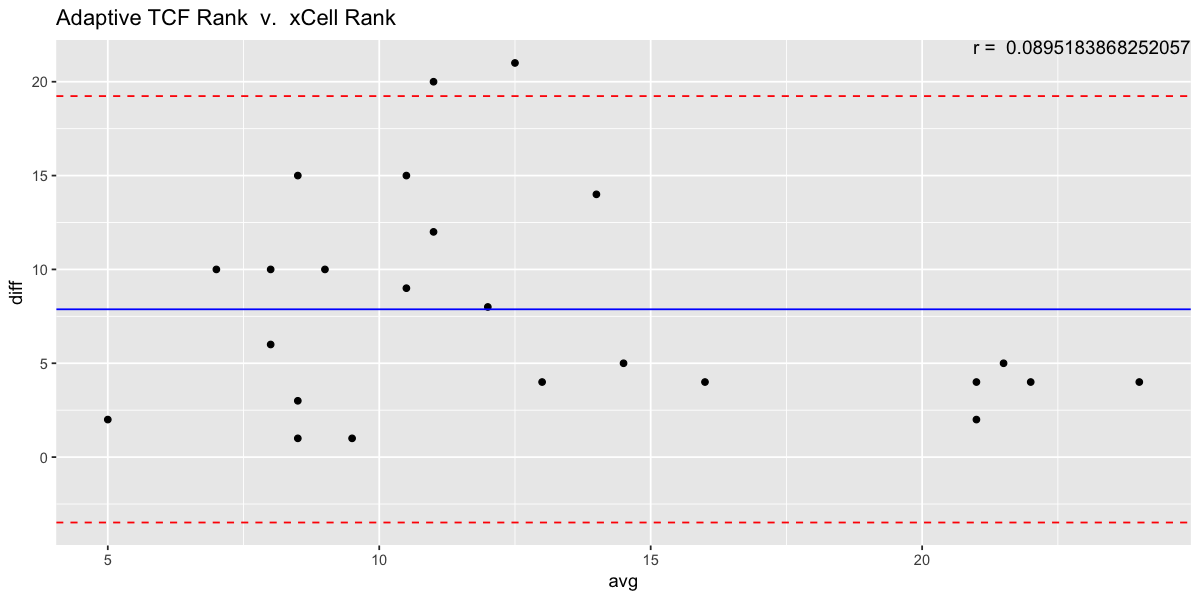

In [38]:
xcell_rank <- xcell %>% mutate(score = rank(score), method = "xCell Rank")
bland_altman_single(adaptive_tcf_rank, xcell_rank)

Log-normalized scores correlate much better, though still poorly.

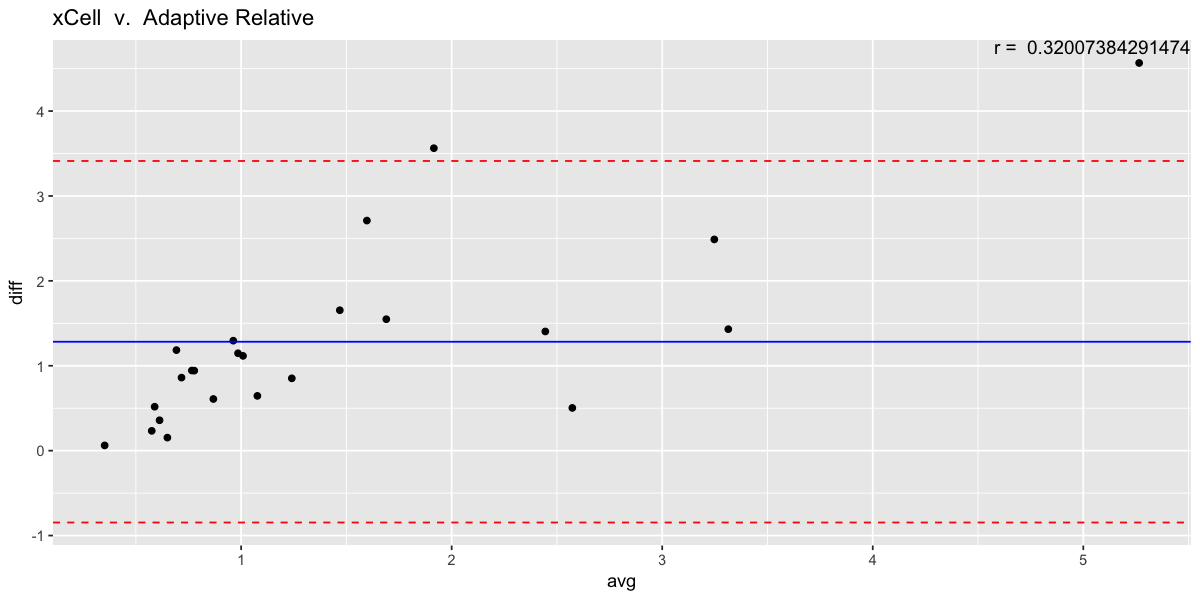

In [39]:
normalized_xcell <-
    xcell %>%
    mutate(score = log(score), score = (score - mean(score)) / sd(score), score = exp(score))

bland_altman_single(normalized_xcell, normalized_adaptive_tcf)

# Tool Comparisons

I mostly settled on using CIBERSORT for the primary analysis, so was not so thorough on this part of the preliminary analysis. This work could be extended significantly.

## CIBERSORT v. MCP-Counter

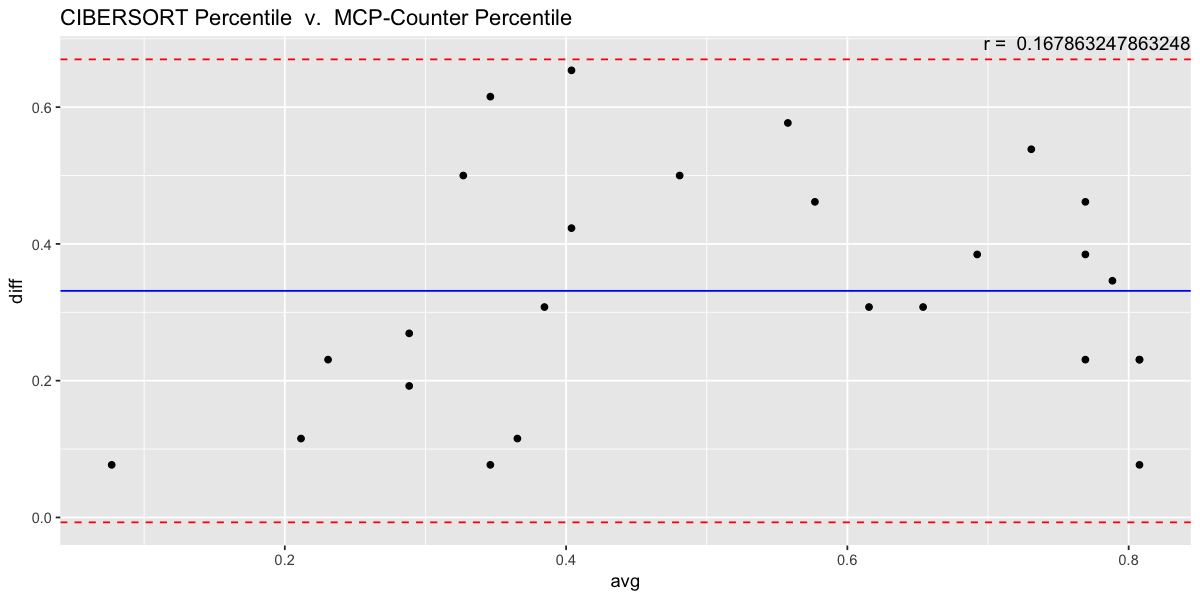

In [40]:
bland_altman_single(cibersort_percentile, mcp_percentile)

## CIBERSORT v. xCell

CIBERSORT consistently overestimates xCell. It is unclear what the denominator of xCell is, as their method for converting GSEA scores to fractional estimates is fairly opaque. That's to say, I'm not sure if this overestimation is expected.

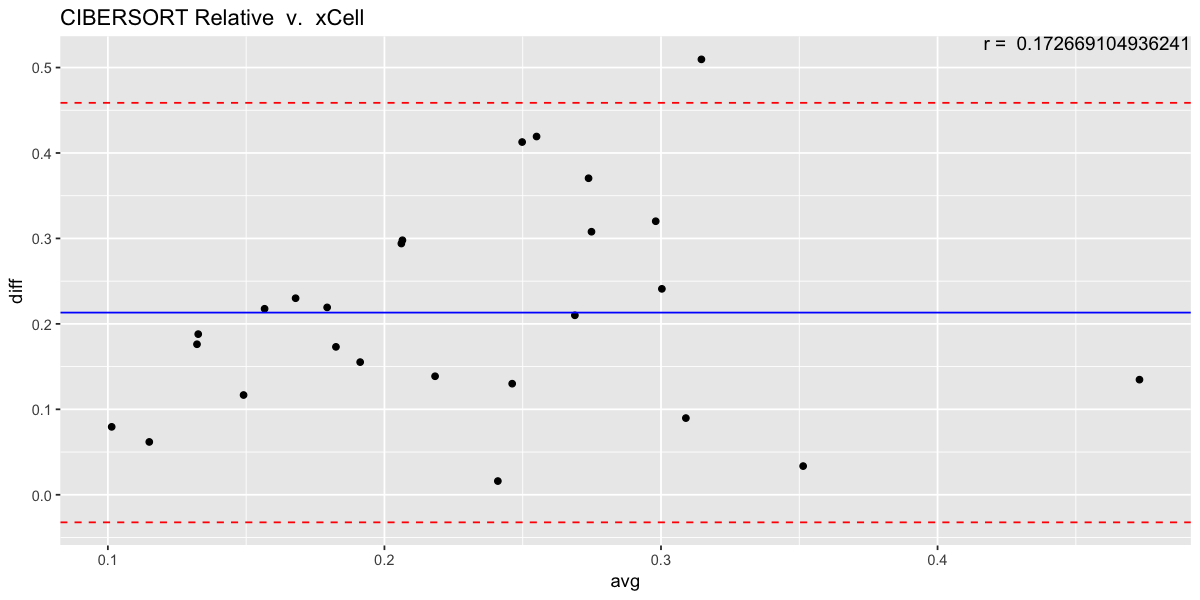

In [49]:
bland_altman_single(cibersort_relative, xcell)

## MCP-Counter v. xCell

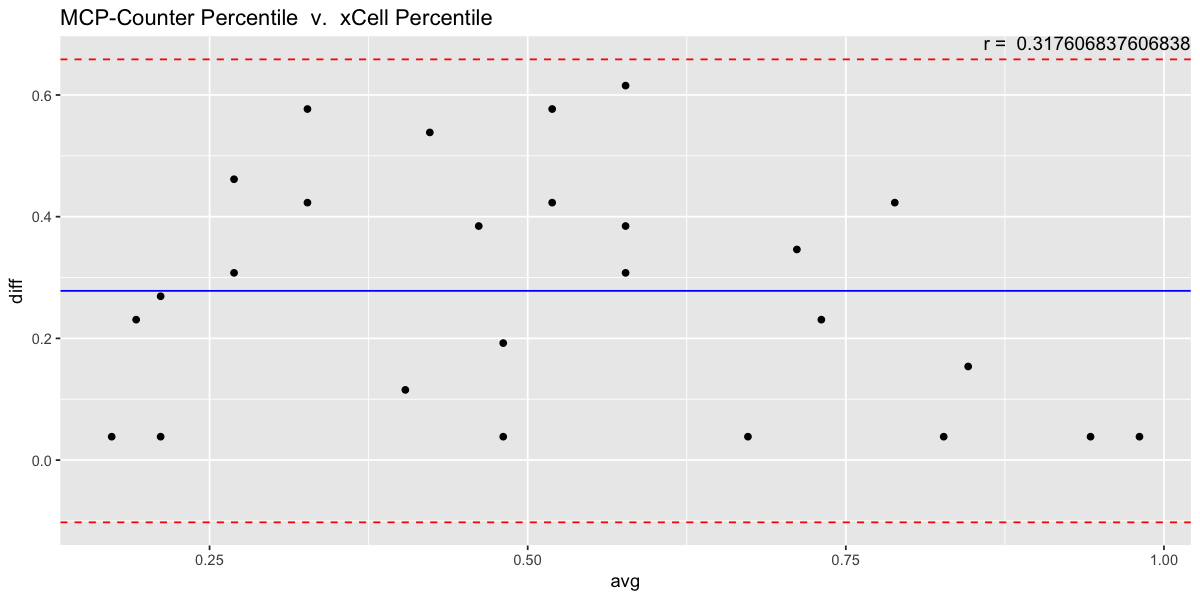

In [42]:
bland_altman_single(mcp_percentile, xcell_percentile)